In [1]:
import shap
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
tornado = pd.read_csv('https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv')
tornado

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.80,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.00,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.10,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.10,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.00,37,1,1,1,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67553,620523,2021,9,8,2021-09-08,15:32:00,3,PA,42,0,...,0.73,30,1,1,1,109,0,0,0,0
67554,620524,2021,9,8,2021-09-08,15:35:00,3,PA,42,0,...,1.45,30,1,1,1,109,0,0,0,0
67555,620525,2021,9,8,2021-09-08,19:08:00,3,FL,12,0,...,1.45,50,1,1,1,129,0,0,0,0
67556,620526,2021,9,9,2021-09-09,02:10:00,3,CT,9,0,...,0.75,75,1,1,1,13,0,0,0,0


In [3]:
clim_df = pd.read_csv('data/climate_indices.csv', index_col=0)
clim_df.index = pd.to_datetime(clim_df.index)
clim_df

,ENSO,PDO,NAO,AO
Date,,,,
1951-01-01,1.5,-1.19,0.08,-0.085
1951-02-01,0.9,-1.52,0.70,-0.400
1951-03-01,-0.1,-1.72,-1.02,-1.934
1951-04-01,-0.3,-1.35,-0.22,-0.776
1951-05-01,-0.7,-1.29,-0.59,-0.863
...,...,...,...,...
2025-08-01,0.4,-3.20,0.26,0.036
2025-09-01,0.0,-2.33,-0.80,0.048
2025-10-01,NaN,-2.40,-0.96,0.064


In [4]:
df_il = tornado[tornado['st']=='IL'].copy()

df_il['date'] = pd.to_datetime(df_il['date'])
df_il['yr'] = df_il['date'].dt.year
df_il['mo'] = df_il['date'].dt.month
df_il['dy'] = df_il['date'].dt.day

In [5]:
mo_count = df_il.groupby(['yr','mo']).size().reset_index(name='monthly_count')
mo_count

,yr,mo,monthly_count
0,1950,1,2
1,1950,3,1
2,1950,6,1
3,1950,7,1
4,1950,12,3
...,...,...,...
440,2021,6,15
441,2021,7,8
442,2021,8,16
443,2021,10,10


In [6]:
mo_count_dates = pd.date_range(start=datetime.datetime(mo_count['yr'].iloc[0],1,1),end=datetime.datetime(mo_count['yr'].iloc[-1],12,1),freq="MS")
inds_df = pd.DataFrame({
    'date':mo_count_dates,
    'yr':mo_count_dates.year,
    'mo':mo_count_dates.month
    })

mo_count = pd.merge(inds_df, mo_count, on=['yr','mo'], how='left')
mo_count['monthly_count'] = mo_count['monthly_count'].fillna(0)
mo_count.set_index('date', inplace=True)
mo_count.dtypes


yr                 int32
mo                 int32
monthly_count    float64
dtype: object

In [7]:
mo_count

,yr,mo,monthly_count
date,,,
1950-01-01,1950,1,2.0
1950-02-01,1950,2,0.0
1950-03-01,1950,3,1.0
1950-04-01,1950,4,0.0
1950-05-01,1950,5,0.0
...,...,...,...
2021-08-01,2021,8,16.0
2021-09-01,2021,9,0.0
2021-10-01,2021,10,10.0


In [8]:
complete_df = pd.merge(mo_count, clim_df, left_index=True, right_index=True, how='left').dropna()
complete_df

,yr,mo,monthly_count,ENSO,PDO,NAO,AO
date,,,,,,,
1951-01-01,1951,1,0.0,1.5,-1.19,0.08,-0.085
1951-02-01,1951,2,0.0,0.9,-1.52,0.70,-0.400
1951-03-01,1951,3,0.0,-0.1,-1.72,-1.02,-1.934
1951-04-01,1951,4,0.0,-0.3,-1.35,-0.22,-0.776
1951-05-01,1951,5,0.0,-0.7,-1.29,-0.59,-0.863
...,...,...,...,...,...,...,...
2021-08-01,2021,8,16.0,0.6,-0.95,-0.28,-0.209
2021-09-01,2021,9,0.0,0.8,-1.96,-0.21,-0.252
2021-10-01,2021,10,10.0,0.7,-3.13,-2.29,-0.146


In [9]:
features = complete_df[['ENSO', 'PDO', 'NAO', 'AO']]
target = complete_df['monthly_count']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=12, shuffle=False
)

In [11]:
rf_model = RandomForestRegressor(random_state=12)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

pearson_corr, _ = pearsonr(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Random Forest Pearson Correlation: {pearson_corr:.2f}')
print(f'Random Forest RMSE: {rmse:.2f}')

Random Forest Pearson Correlation: 0.02
Random Forest RMSE: 8.83


Text(0, 0.5, 'Predicted Monthly Tornado Count')

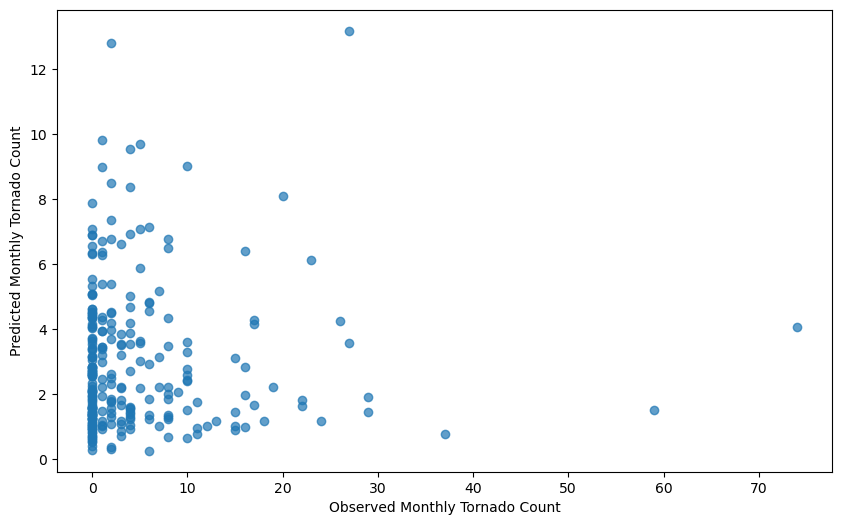

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, y_pred, alpha=0.7)

ax.set_xlabel('Observed Monthly Tornado Count')
ax.set_ylabel('Predicted Monthly Tornado Count')

In [13]:
# Try without drop='first'
encoder = OneHotEncoder(sparse_output=False)
mo_encoded = encoder.fit_transform(complete_df[['mo']])

mo_encoded_df = pd.DataFrame(mo_encoded, index=complete_df.index, columns=[f'mo_{i+1}' for i in range(mo_encoded.shape[1])])
complete_df_enc = pd.concat([complete_df, mo_encoded_df], axis=1)
complete_df_enc

,yr,mo,monthly_count,ENSO,PDO,NAO,AO,mo_1,mo_2,mo_3,mo_4,mo_5,mo_6,mo_7,mo_8,mo_9,mo_10,mo_11,mo_12
date,,,,,,,,,,,,,,,,,,,
1951-01-01,1951,1,0.0,1.5,-1.19,0.08,-0.085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951-02-01,1951,2,0.0,0.9,-1.52,0.70,-0.400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951-03-01,1951,3,0.0,-0.1,-1.72,-1.02,-1.934,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951-04-01,1951,4,0.0,-0.3,-1.35,-0.22,-0.776,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951-05-01,1951,5,0.0,-0.7,-1.29,-0.59,-0.863,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,2021,8,16.0,0.6,-0.95,-0.28,-0.209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-09-01,2021,9,0.0,0.8,-1.96,-0.21,-0.252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-10-01,2021,10,10.0,0.7,-3.13,-2.29,-0.146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
feature_enc_names = ['ENSO', 'PDO', 'NAO', 'AO'] + [f'mo_{i+1}' for i in range(mo_encoded.shape[1])]
features_enc = complete_df_enc[feature_enc_names]
target_enc = complete_df_enc['monthly_count']

In [15]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    features_enc, target_enc, test_size=0.3, random_state=12, shuffle=False
)

In [16]:
rf_model = RandomForestRegressor(random_state=12)
rf_model.fit(X_train_enc, y_train_enc)

y_pred_enc = rf_model.predict(X_test_enc)

pearson_corr, _ = pearsonr(y_test_enc, y_pred_enc)
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred_enc))
print(f'Random Forest Pearson Correlation with one-hot encoding: {pearson_corr:.2f}')
print(f'Random Forest RMSE with one-hot encoding: {rmse:.2f}')

Random Forest Pearson Correlation with one-hot encoding: 0.36
Random Forest RMSE with one-hot encoding: 8.13


Text(0, 0.5, 'Predicted (with one-hot encoding) Monthly Tornado Count')

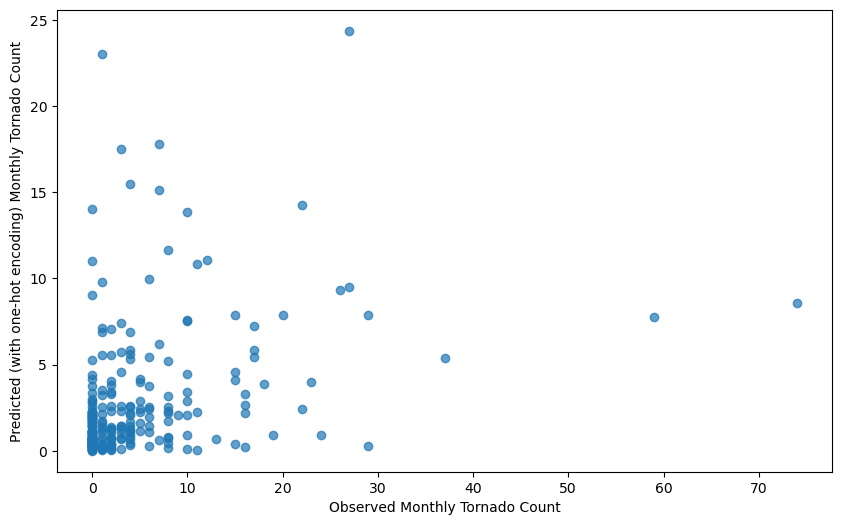

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test_enc, y_pred_enc, alpha=0.7)

ax.set_xlabel('Observed Monthly Tornado Count')
ax.set_ylabel('Predicted (with one-hot encoding) Monthly Tornado Count')

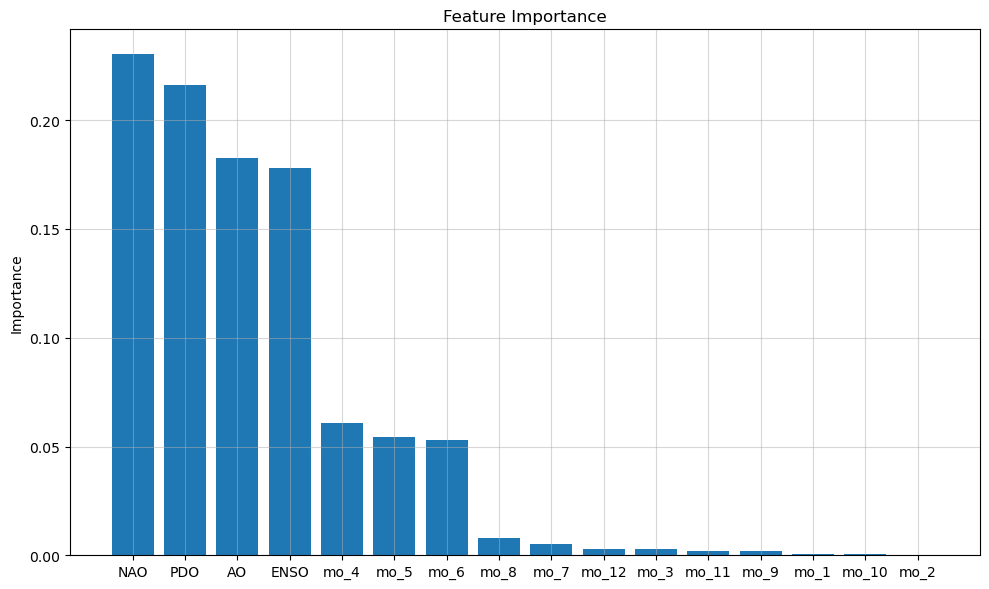

In [18]:
# Feature importance
feature_importance_month = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importance_month)[::-1]

plt.bar(range(len(feature_importance_month)), feature_importance_month[indices])
plt.xticks(range(len(feature_importance_month)), [feature_enc_names[i] for i in indices])
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

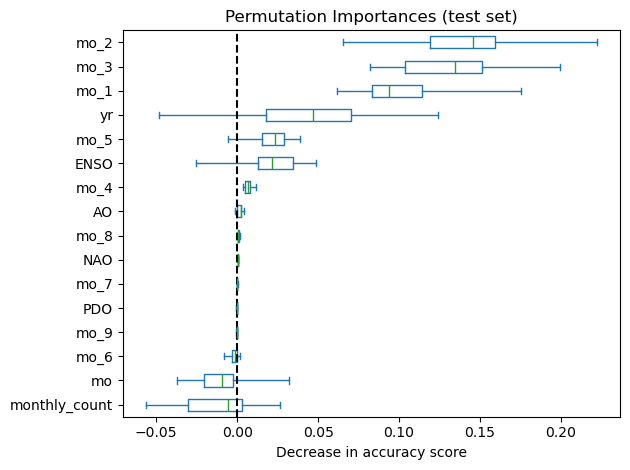

In [19]:
# Permutation importance
result = permutation_importance(
    rf_model, X_test_enc, y_test_enc, n_repeats=10, random_state=12
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=complete_df_enc.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [21]:
shap.initjs()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_enc)
shap_values

array([[-1.05153104e-03,  2.87837575e-02,  2.61775525e-01, ...,
         2.01294289e-04, -4.42664057e-02, -6.44091835e-03],
       [ 1.25413501e-01, -4.90935454e-02, -2.36764370e-01, ...,
         2.75107642e-02, -2.92274662e-02, -2.06121955e-02],
       [ 1.09095775e+00, -3.90057295e-01, -3.35108474e-01, ...,
        -3.04416043e-03,  2.48084739e-01, -1.92796491e-02],
       ...,
       [-7.53127434e-02,  2.18527006e+00,  7.77106798e-01, ...,
         1.38068021e-02, -5.89242014e-02, -1.33842363e-02],
       [ 7.93234440e-02,  2.14097892e+00,  2.97063218e-01, ...,
        -2.02390744e-03,  2.86995691e-01, -1.62406487e-02],
       [ 3.06652331e-01,  1.90590726e+00, -5.09353115e-02, ...,
        -1.21475101e-03, -6.91852147e-02,  9.84214492e-02]],
      shape=(256, 16))

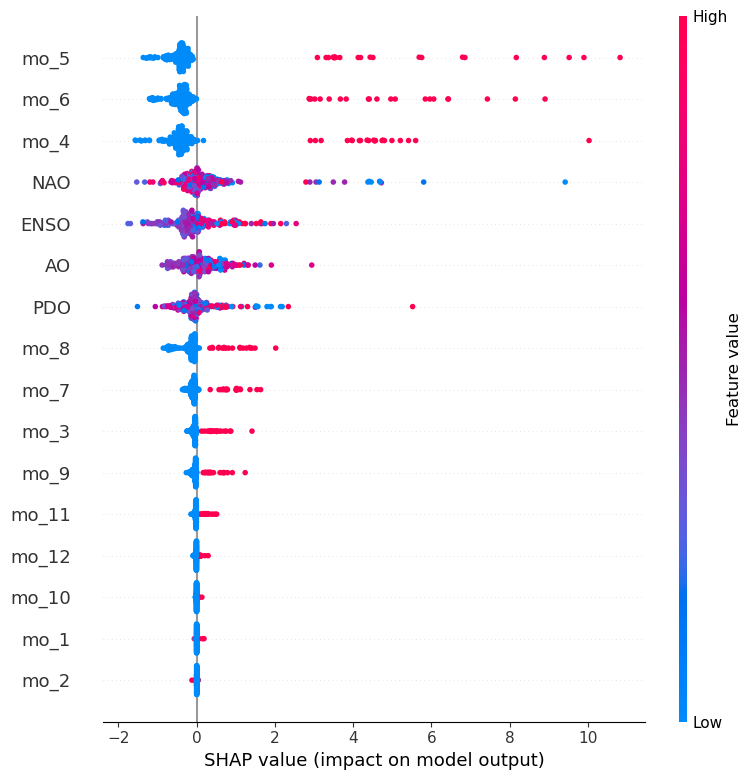

In [22]:
shap.summary_plot(shap_values, X_test_enc, feature_names=feature_enc_names)

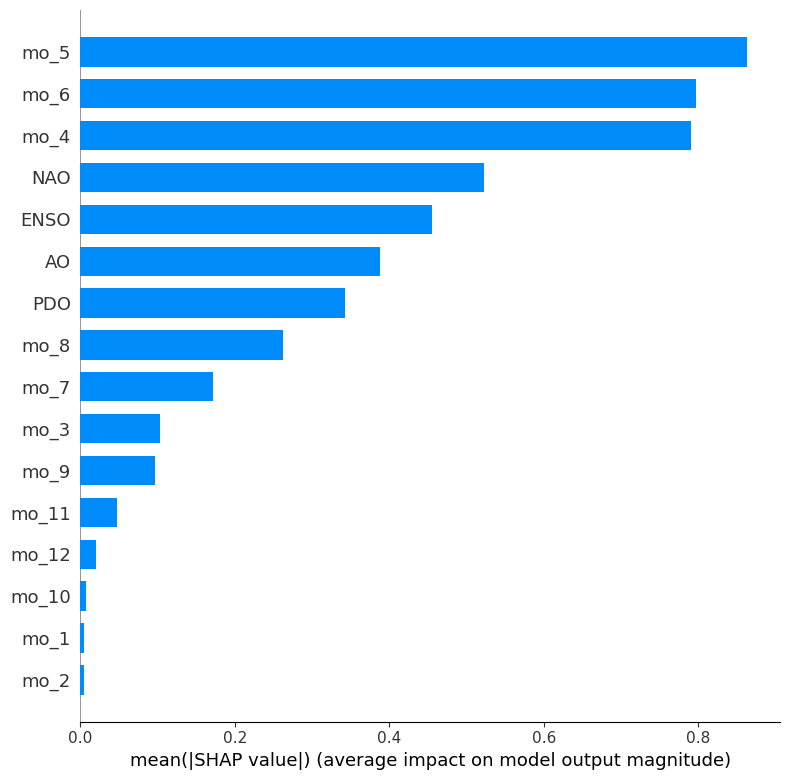

In [23]:
shap.summary_plot(shap_values, X_test_enc, feature_names=feature_enc_names, plot_type="bar")

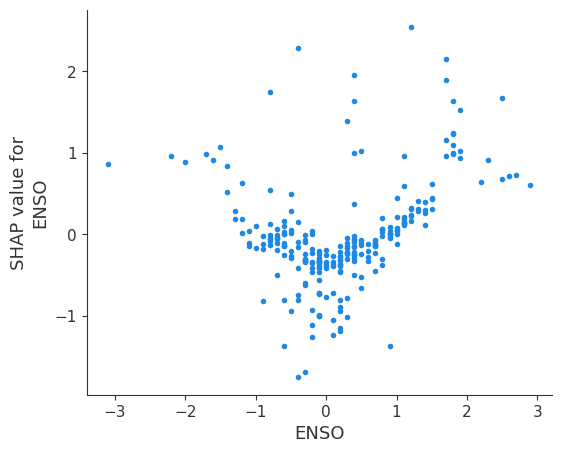

In [25]:
shap.dependence_plot('ENSO', shap_values, X_test_enc, feature_names=feature_enc_names, interaction_index=None)

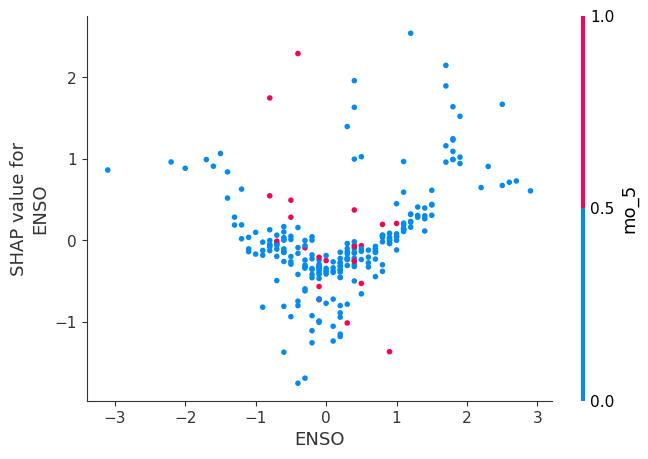

In [26]:
shap.dependence_plot('ENSO', shap_values, X_test_enc, feature_names=feature_enc_names, interaction_index='mo_5')

MDI ranks the importance of the climate indices much higher than the other importance metrics. Permutation importance shows that certain months are much better predictors than the climate indices. The SHAP summary shows the same when it comes to the months, but the individual months do not agree with the permutation importance rankings, highlighting the impact of certain months on local predictions.
